# 基于Guided Grad-CAM的高分辨率细粒度可解释性分析

对单张图像，进行Guided Grad-CAM可解释性分析，绘制既具有类别判别性（Class-Discriminative），又具有高分辨率的细粒度热力图。

同济子豪兄 https://space.bilibili.com/1900783

代码运行云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1

2022-9-21

In [1]:
import numpy as np
import cv2
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import models
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad, GradCAMElementWise
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入模型

In [2]:
model = torch.load('checkpoint/fruit30_pytorch_20220814.pth')
model = model.eval().to(device)

In [3]:
idx_to_labels_cn = np.load('idx_to_labels.npy', allow_pickle=True).item()
idx_to_labels_cn

{0: '哈密瓜',
 1: '圣女果',
 2: '山竹',
 3: '杨梅',
 4: '柚子',
 5: '柠檬',
 6: '桂圆',
 7: '梨',
 8: '椰子',
 9: '榴莲',
 10: '火龙果',
 11: '猕猴桃',
 12: '石榴',
 13: '砂糖橘',
 14: '胡萝卜',
 15: '脐橙',
 16: '芒果',
 17: '苦瓜',
 18: '苹果-红',
 19: '苹果-青',
 20: '草莓',
 21: '荔枝',
 22: '菠萝',
 23: '葡萄-白',
 24: '葡萄-红',
 25: '西瓜',
 26: '西红柿',
 27: '车厘子',
 28: '香蕉',
 29: '黄瓜'}

## 图像预处理

In [4]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(224),
                                     # transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入测试图片

In [5]:
img_path = 'test_img/test_fruits.jpg'

In [6]:
img_pil = Image.open(img_path)

In [7]:
# img_pil

In [8]:
input_tensor = test_transform(img_pil).unsqueeze(0).to(device) # 预处理

In [9]:
input_tensor.shape

torch.Size([1, 3, 224, 298])

## 选择可解释性分析方法

In [10]:
# GradCAM
from pytorch_grad_cam import GradCAM
target_layers = [model.layer4[-1]] # 要分析的层
targets = [ClassifierOutputTarget(28)] # 要分析的类别
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

## 生成Grad-CAM热力图

In [11]:
cam_map = cam(input_tensor=input_tensor, targets=targets)[0] # 不加平滑
# cam_map = cam(input_tensor=input_tensor, targets=targets, aug_smooth=True, eigen_smooth=True)[0] # 加平滑

In [12]:
cam_map.shape

(224, 298)

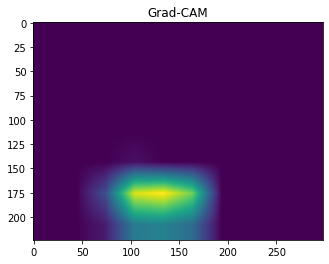

In [13]:
plt.imshow(cam_map)
plt.title('Grad-CAM')
plt.show()

In [14]:
import torchcam
from torchcam.utils import overlay_mask

result = overlay_mask(img_pil, Image.fromarray(cam_map), alpha=0.5) # alpha越小，原图越淡

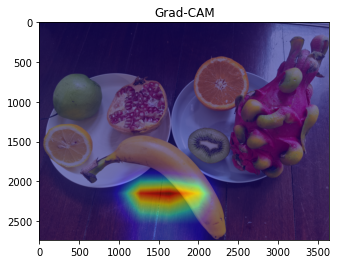

In [15]:
plt.imshow(result)
plt.title('Grad-CAM')
plt.show()

## Guided Backpropagation算法

In [18]:
# 初始化算法
gb_model = GuidedBackpropReLUModel(model=model, use_cuda=True)

In [21]:
# 生成 Guided Backpropagation热力图
gb_origin = gb_model(input_tensor, target_category=None)
gb_show = deprocess_image(gb_origin)

In [23]:
gb_show.shape

(224, 298, 3)

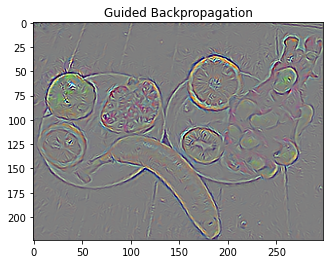

In [25]:
plt.imshow(gb_show)
plt.title('Guided Backpropagation')
plt.show()

## 将Grad-CAM热力图与Gudied Backpropagation热力图逐元素相乘

In [26]:
# Grad-CAM三通道热力图
cam_mask = cv2.merge([cam_map, cam_map, cam_map])

In [27]:
cam_mask.shape

(224, 298, 3)

In [28]:
# 逐元素相乘
guided_gradcam = deprocess_image(cam_mask * gb_origin)

In [29]:
guided_gradcam.shape

(224, 298, 3)

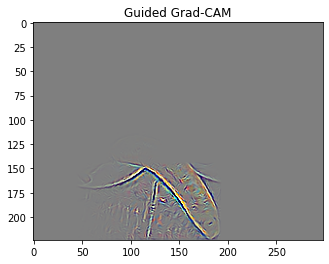

In [30]:
plt.imshow(guided_gradcam)
plt.title('Guided Grad-CAM')
plt.show()

In [31]:
cv2.imwrite('output/C2_guided_gradcam.jpg', guided_gradcam)

True

## 思考题

Guided Backpropagation确实兼顾了高分辨率和class-discriminative，唯一美中不足的就是可视化效果太不锐利

是否可以进行进一步的图像处理，更适合人眼来看